In [77]:
from scipy.stats import rankdata
import random
import copy
from tqdm import tqdm

In [78]:
ONE_MAKI = 'One maki' # Card type
TWO_MAKI = 'Two maki' # Card type
THREE_MAKI = 'Three maki' # Card type
WASABI_SQUID = 'Wasabi Squid' # Board type
WASABI_SALMON = 'Wasabi Salmon' # Board type
WASABI_EGG = 'Wasabi Egg' # Board type
MAKI = 'Maki' # Board type

TEMPURA = 'Tempura' # Board and card type for rest
SASHIMI = 'Sashimi'
DUMPLINGS = 'Dumplings'
SQUID_NIGIRI = 'Squid Nigiri'
SALMON_NIGIRI = 'Salmon Nigiri'
EGG_NIGIRI = 'Egg Nigiri'
WASABI = 'Wasabi'
PUDDING = 'Pudding'

CHOPSTICKS = 'Chopsticks' # Unused just included for completeness

HAND_TO_INDEX = { # for cards in hand
    ONE_MAKI: 0,
    TWO_MAKI : 1,
    THREE_MAKI : 2,
    TEMPURA : 3,
    SASHIMI : 4,
    DUMPLINGS : 5,
    SQUID_NIGIRI : 6,
    SALMON_NIGIRI : 7,
    EGG_NIGIRI : 8,
    WASABI : 9,
    PUDDING : 10,
    CHOPSTICKS : 11 # unsed
}

BOARD_TO_INDEX = { # for board representation
    MAKI : 0,
    TEMPURA : 1,
    SASHIMI : 2,
    DUMPLINGS : 3,
    SQUID_NIGIRI : 4,
    SALMON_NIGIRI : 5,
    EGG_NIGIRI : 6,
    WASABI_SQUID : 7,
    WASABI_SALMON : 8,
    WASABI_EGG : 9,
    WASABI : 10,
    PUDDING : 11,
    CHOPSTICKS : 12 # unused
}

def score(board):
    score = 0
    num_dumplings = board[BOARD_TO_INDEX[DUMPLINGS]]
    if num_dumplings == 1:
        score += 1
    if num_dumplings == 2:
        score += 3
    if num_dumplings== 3:
        score += 6
    if num_dumplings == 4:
        score += 10
    if num_dumplings > 4:
        score += 15
    
    score += board[BOARD_TO_INDEX[SASHIMI]] // 3 * 10
    score += board[BOARD_TO_INDEX[TEMPURA]] // 2 * 5  
     
    score += board[BOARD_TO_INDEX[EGG_NIGIRI]] * 1   
    score += board[BOARD_TO_INDEX[SALMON_NIGIRI]] * 2 
    score += board[BOARD_TO_INDEX[SQUID_NIGIRI]] * 3  
    
    score += board[BOARD_TO_INDEX[WASABI_EGG]] * 3 
    score += board[BOARD_TO_INDEX[WASABI_SALMON]] * 6  
    score += board[BOARD_TO_INDEX[WASABI_SQUID]] * 9  

    return score


def add_card(board, card):
    if card == HAND_TO_INDEX[SASHIMI]:
        board[BOARD_TO_INDEX[SASHIMI]] += 1
    if card == HAND_TO_INDEX[EGG_NIGIRI]:
        if board[BOARD_TO_INDEX[WASABI]] > 0:
            board[BOARD_TO_INDEX[WASABI]] -= 1
            board[BOARD_TO_INDEX[WASABI_EGG]] += 1 
        else:
            board[BOARD_TO_INDEX[EGG_NIGIRI]] += 1
    if card == HAND_TO_INDEX[SALMON_NIGIRI]:
        if board[BOARD_TO_INDEX[WASABI]] > 0:
            board[BOARD_TO_INDEX[WASABI]] -= 1
            board[BOARD_TO_INDEX[WASABI_SALMON]] += 1 
        else:
            board[BOARD_TO_INDEX[SALMON_NIGIRI]] += 1
    if card == HAND_TO_INDEX[SQUID_NIGIRI]:
        if board[BOARD_TO_INDEX[WASABI]] > 0:
            board[BOARD_TO_INDEX[WASABI]] -= 1
            board[BOARD_TO_INDEX[WASABI_SQUID]] += 1 
        else:
            board[BOARD_TO_INDEX[SQUID_NIGIRI]] += 1
    if card == HAND_TO_INDEX[ONE_MAKI]:
        board[BOARD_TO_INDEX[MAKI]] += 1
    if card == HAND_TO_INDEX[TWO_MAKI]:
        board[BOARD_TO_INDEX[MAKI]] += 2
    if card == HAND_TO_INDEX[THREE_MAKI]:
        board[BOARD_TO_INDEX[MAKI]] += 3
    if card == HAND_TO_INDEX[TEMPURA]:
        board[BOARD_TO_INDEX[TEMPURA]] += 1
    if card == HAND_TO_INDEX[DUMPLINGS]:
        board[BOARD_TO_INDEX[DUMPLINGS]] += 1
    if card == HAND_TO_INDEX[PUDDING]:
        board[BOARD_TO_INDEX[PUDDING]] += 1
    if card == HAND_TO_INDEX[WASABI]:
        board[BOARD_TO_INDEX[WASABI]] += 1


def score_maki(maki_counts):
    maki_scores = []
    maki_rank = rankdata([maki_count * -1 for maki_count in maki_counts], method='min')
    for rank in maki_rank:
        if rank == 1:
            maki_scores.append(6)
        elif rank == 2:
            maki_scores.append(3)
        else:
            maki_scores.append(0)
    return maki_scores

def score_pudding(pudding_counts):
    pudding_score = []
    pudding_rank = rankdata([pudding_count * -1 for pudding_count in pudding_counts], method='min')
    lowest_rank = max(pudding_rank)
    for rank in pudding_rank:
        if rank == 1:
            pudding_score.append(6)
        elif rank == lowest_rank:
            pudding_score.append(-6)
        else:
            pudding_score.append(0)
    return pudding_score

In [79]:
class SkeletonPlayer:

    def __init__(self, name):
        self.name = name
        self.hand = []
        self.board = [0] * 13
        self.next_round()

    def draw(self, card):
        self.hand.append(card)

    def pick_card(self):
        raise NotImplementedError

    def get_score(self):
        return score(self.board)

    def reward(self, reward):
        raise NotImplementedError

    def next_round(self):
        self.hand = []
        pudding_count = self.board[BOARD_TO_INDEX[PUDDING]]
        self.board = [0] * 13
        self.board[BOARD_TO_INDEX[PUDDING]] = pudding_count

    def next_game(self):
        self.hand = []
        self.board = [0] * 13


class RandomPlayer(SkeletonPlayer):

    def __init__(self, name):
        super().__init__(name)
        self.next_round()

    def draw(self, card):
        self.hand.append(card)

    def pick_card(self):
        random.shuffle(self.hand)
        action = self.hand.pop()
        add_card(self.board, action)

    def reward(self, reward):
        # Doesn't do anything with it
        return

class DumplingPlayer(SkeletonPlayer):

    def __init__(self, name):
        super().__init__(name)
        self.next_round()

    def draw(self, card):
        self.hand.append(card)

    def pick_card(self):
        if HAND_TO_INDEX[DUMPLINGS] in self.hand:
            action = HAND_TO_INDEX[DUMPLINGS]
            self.hand.remove(HAND_TO_INDEX[DUMPLINGS])
        else:
            random.shuffle(self.hand)
            action = self.hand.pop()
        add_card(self.board, action)

    def reward(self, reward):
        # Doesn't do anything with it
        return

class QLearnPlayer(SkeletonPlayer):

    def __init__(self, name):
        super().__init__(name)
        self.decay_gamma = 0.9
        self.lr = 0.01
        self.exp_rate = 0.3
        self.hits = 0
        self.querys = 0

        self.model_dict = {}

        self.next_round()

    def draw(self, card):
        self.hand.append(card)

    def pick_card(self):
        action = None
        max_value = -100
        for possible_next_card in set(self.hand):
            board = copy.copy(self.board)
            add_card(board, possible_next_card)
            self.querys += 1
            if str(board) in self.model_dict:
                self.hits += 1
            value = self.model_dict.get(str(board), 0) + random.random() / 1e6
            if value > max_value:
                max_value = value
                action = possible_next_card

        # Take a card based on action
        self.hand.remove(action)
        add_card(self.board, action)

        # Add state to memory
        self.states_in_game.append(str(self.board))

    def reward(self, reward):
        for state in self.states_in_game[::-1]:
            if state not in self.model_dict:
                self.model_dict[state] = 0
            self.model_dict[state] += (reward - self.model_dict[state]) * self.lr
            reward *= self.decay_gamma

    def next_round(self):
        super().next_round()
        self.states_in_game = []
        self.states_in_game.append(str(self))

In [80]:
class SushiGo:

    def __init__(self, players):
        self.cards = self.get_all_cards()
        self.players = players
        self.starting_hand_size = self.determine_starting_hand_size()
        self.scores = [0] * len(players)

    def add_player(self, player):
        self.players.append(player)
    
    def get_all_cards(self):
        result = []
        result.extend([HAND_TO_INDEX[TEMPURA]] * 14)
        result.extend([HAND_TO_INDEX[SASHIMI]] * 14)
        result.extend([HAND_TO_INDEX[DUMPLINGS]] * 14)
        result.extend([HAND_TO_INDEX[ONE_MAKI]] * 6)
        result.extend([HAND_TO_INDEX[TWO_MAKI]] * 12)
        result.extend([HAND_TO_INDEX[THREE_MAKI]] * 8)
        result.extend([HAND_TO_INDEX[EGG_NIGIRI]] * 5)
        result.extend([HAND_TO_INDEX[SALMON_NIGIRI]] * 10)
        result.extend([HAND_TO_INDEX[SQUID_NIGIRI]] * 5)
        result.extend([HAND_TO_INDEX[PUDDING]] * 10)
        result.extend([HAND_TO_INDEX[WASABI]] * 6)

        return result
    
    def determine_starting_hand_size(self):
        num_players = len(self.players)
        if num_players == 2:
            return 10
        elif num_players == 3:
            return 9
        elif num_players == 4:
            return 8
        elif num_players == 5:
            return 7
        raise Exception('Unrecognized number of players must be between 2 - 5 players')

    def deal(self):
        for p in self.players:
            p.next_round()
            for _ in range(self.starting_hand_size):
                random.shuffle(self.cards)
                p.draw(self.cards.pop())
    
    def pass_around_hands(self):
        last_hand = self.players[-1].hand
        for i in range(len(self.players) - 1, 0, -1):
            self.players[i].hand = self.players[i - 1].hand  
        self.players[0].hand = last_hand  

    def reset(self):
        self.cards = self.get_all_cards()
        self.scores = [0] * len(self.players)

    def play(self, num_rounds=1):
        self.scores = [0] * len(self.players)
        for p in self.players:
            p.next_game()

        for round in range(num_rounds):
            self.deal()
            for turn in range(self.starting_hand_size):
                for p in self.players:
                    p.pick_card()
                self.pass_around_hands()
            for i, p in enumerate(self.players):
                self.scores[i] += p.get_score()

            maki_score = score_maki([p.board[BOARD_TO_INDEX[MAKI]] for p in self.players])
            for i in range(len(maki_score)):
                self.scores[i] += maki_score[i]

        # Adjustment for Pudding
        pudding_score = score_pudding([p.board[BOARD_TO_INDEX[PUDDING]] for p in self.players])
        for i in range(len(pudding_score)):
            self.scores[i] += pudding_score[i]

        highest_score = max(self.scores)
        for i, p in enumerate(self.players):
            if self.scores[i] == highest_score:
                self.player_games_won[i] += 1
                p.reward(2)  
            else:
                p.reward(-1)

    def play_games(self, num_games=1, round_per_game=3):
        self.player_games_won = [0] * len(self.players)
        for _ in range(num_games):
            self.reset()
            self.play(round_per_game)
   
        

In [71]:
p1 = QLearnPlayer('Q-learning Player')
p2 = RandomPlayer('Random Player')
p3 = DumplingPlayer('Dumpling Player')
state = SushiGo([p1, p2, p3])
all_results = []
  
for i in tqdm(range(100)):
    state.play_games(num_games=200)
    all_results.append(state.player_games_won)

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


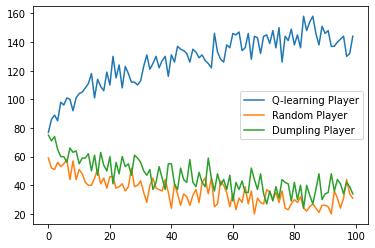

In [75]:
from matplotlib import pyplot as plt
%matplotlib inline

x = [i for i in range(100)]
player1y = [arr[0] for arr in all_results]
player2y = [arr[1] for arr in all_results]
player3y = [arr[2] for arr in all_results]

plt.plot(x, player1y, label = "Q-learning Player")
plt.plot(x, player2y, label = "Random Player")
plt.plot(x, player3y, label = "Dumpling Player")
plt.legend()
plt.show()


In [81]:
p4 = QLearnPlayer('Q-learning Player 1')
p5 = QLearnPlayer('Q-learning Player 2')
p5.lr = 0.03 
p5.decay_gamma = 0.95
p6 = QLearnPlayer('Q-learning Player 3')
p6.lr = 0.005
p6.decay_gamma = 0.8
state = SushiGo([p4, p5, p6])
all_results2 = []
  
for i in tqdm(range(100)):
    state.play_games(num_games=200)
    all_results2.append(state.player_games_won)

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


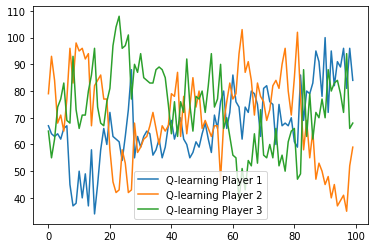

In [85]:
x = [i for i in range(100)]
player4y = [arr[0] for arr in all_results2]
player5y = [arr[1] for arr in all_results2]
player6y = [arr[2] for arr in all_results2]

plt.plot(x, player4y, label = "Q-learning Player 1")
plt.plot(x, player5y, label = "Q-learning Player 2")
plt.plot(x, player6y, label = "Q-learning Player 3")
plt.legend()
plt.show()
